<a href="https://colab.research.google.com/github/prasishcodes/Final_Assignments/blob/main/2462363_Prasish_Dangol_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#1.Load and Explore Data

In [4]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Final Assignment/food_hygiene_rating_data (1).csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (24352, 13)

First few rows:


,Unnamed: 0,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,PostCode,RatingValue,RatingKey,RatingDate,LocalAuthorityCode,LocalAuthorityName,Longitude,Latitude
0,0,1438654,21/00856/FOOD,1st Base Catering,Mobile caterer,E20 2ST,AwaitingInspection,fhrs_awaitinginspection_en-GB,NaN,525,Newham,-0.018066,51.538799
1,1,1132140,19/00459/FOOD,53.5 Degrees,Restaurant/Cafe/Canteen,E16 2RD,5,fhrs_5_en-GB,2019-05-10,525,Newham,0.064757,51.507405
2,2,1132134,19/00447/FOOD,53.5 Degrees,Restaurant/Cafe/Canteen,E15 4LZ,5,fhrs_5_en-GB,2019-05-14,525,Newham,0.009809,51.543395
3,3,1260384,20/00288/FOOD,55 Square Limited,Restaurant/Cafe/Canteen,E16 1EN,2,fhrs_2_en-GB,2020-12-09,525,Newham,0.012417,51.517514
4,4,1389145,21/00354/FOOD,7 Mamas Ltd,Takeaway/sandwich shop,E6 3HN,5,fhrs_5_en-GB,2022-01-05,525,Newham,0.055372,51.527803



Class Distribution:
RatingValue
0                        140
1                        550
2                        675
3                       2450
4                       4483
5                      12544
AwaitingInspection      2439
AwaitingPublication        1
Exempt                  1070
Name: count, dtype: int64


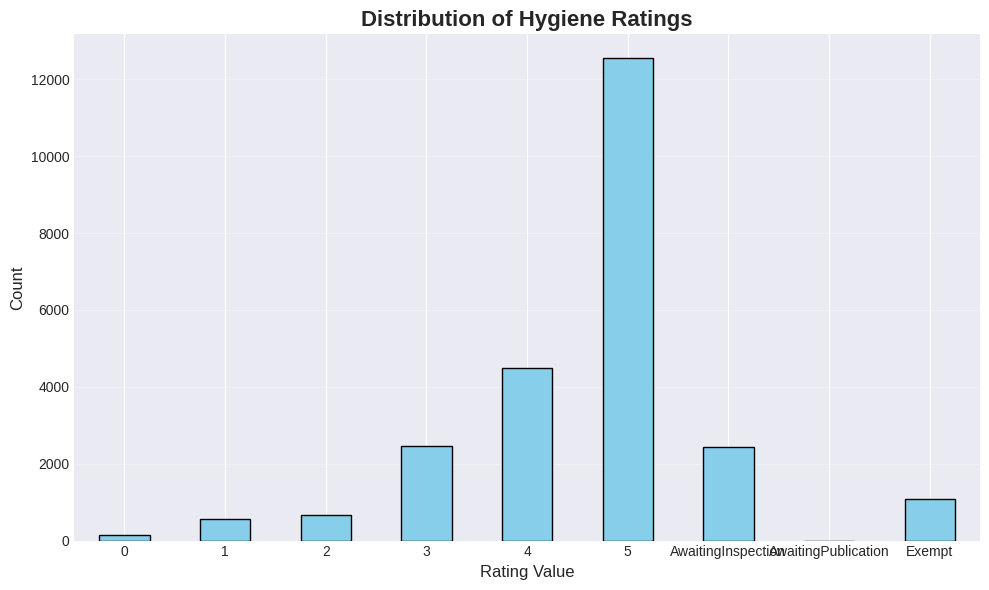


⚠️ CLASS IMBALANCE DETECTED - Will address this using SMOTE and class weights


In [5]:
# Check class distribution
print("\nClass Distribution:")
print(df['RatingValue'].value_counts().sort_index())

# Visualize class distribution
plt.figure(figsize=(10, 6))
df['RatingValue'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Hygiene Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ CLASS IMBALANCE DETECTED - Will address this using SMOTE and class weights")

#2.Data Preprocessing

In [6]:
# Filter valid ratings
valid_ratings = ['0', '1', '2', '3', '4', '5']
df_filtered = df[df['RatingValue'].isin(valid_ratings)].copy()

# Convert to numeric
df_filtered['RatingValue'] = pd.to_numeric(df_filtered['RatingValue'])

# Encode BusinessType
le = LabelEncoder()
df_filtered['BusinessType_Encoded'] = le.fit_transform(df_filtered['BusinessType'])

# Select features
features = ['Longitude', 'Latitude', 'BusinessType_Encoded']
X = df_filtered[features]
y = df_filtered['RatingValue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())

Training set: (16673, 3)
Test set: (4169, 3)

Class distribution in training set:
RatingValue
0      112
1      440
2      540
3     1960
4     3586
5    10035
Name: count, dtype: int64


#3.Handle Class Imbalance with SMOTE


📊 Class Distribution After SMOTE:
RatingValue
0    10035
1    10035
2    10035
3    10035
4    10035
5    10035
Name: count, dtype: int64


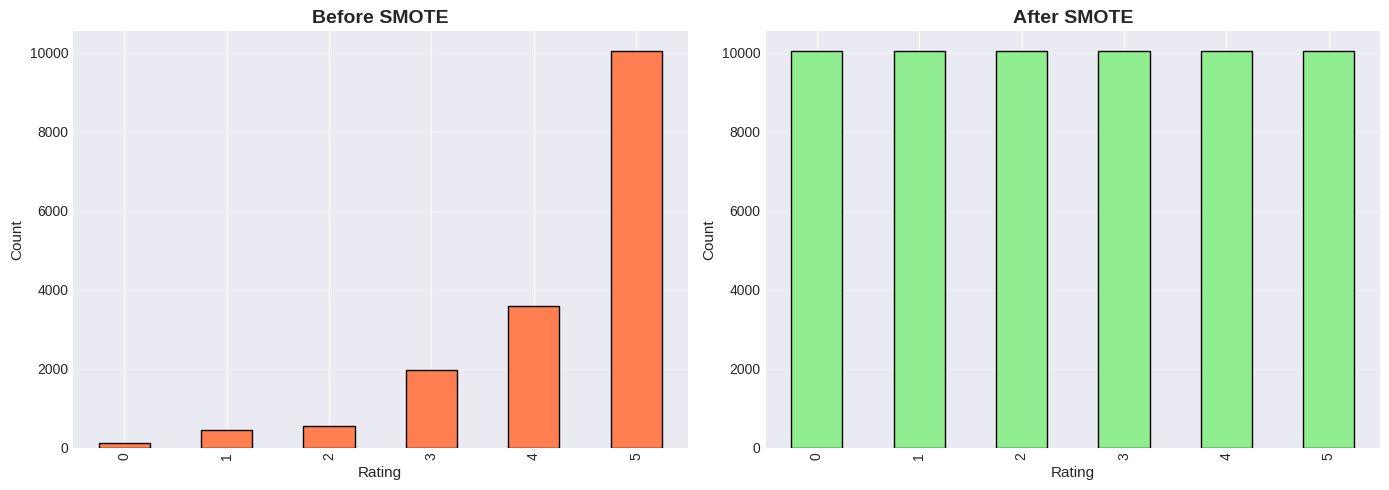

In [7]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n📊 Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts().sort_index())

# Visualize before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# After SMOTE
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rating', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#4.Train Multiple Models

In [8]:
# Dictionary to store all models and their predictions
models_dict = {}
predictions_dict = {}
probabilities_dict = {}

# 1. Logistic Regression (with class weights)
print("\n Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)
models_dict['Logistic Regression'] = lr_model
predictions_dict['Logistic Regression'] = lr_model.predict(X_test_scaled)
probabilities_dict['Logistic Regression'] = lr_model.predict_proba(X_test_scaled)

# 2. Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
dt_model.fit(X_train_balanced, y_train_balanced)
models_dict['Decision Tree'] = dt_model
predictions_dict['Decision Tree'] = dt_model.predict(X_test_scaled)
probabilities_dict['Decision Tree'] = dt_model.predict_proba(X_test_scaled)

# 3. Random Forest (default)
print("Training Random Forest (Default)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)
models_dict['Random Forest'] = rf_model
predictions_dict['Random Forest'] = rf_model.predict(X_test_scaled)
probabilities_dict['Random Forest'] = rf_model.predict_proba(X_test_scaled)

# 4. Random Forest (Tuned)
print("Training Random Forest (Hyperparameter Tuned)...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)
grid_search.fit(X_train_balanced, y_train_balanced)
rf_tuned = grid_search.best_estimator_
models_dict['RF Tuned'] = rf_tuned
predictions_dict['RF Tuned'] = rf_tuned.predict(X_test_scaled)
probabilities_dict['RF Tuned'] = rf_tuned.predict_proba(X_test_scaled)

print(f"\n Best parameters: {grid_search.best_params_}")
print("\nAll models trained successfully!")


 Training Logistic Regression...
Training Decision Tree...
Training Random Forest (Default)...
Training Random Forest (Hyperparameter Tuned)...

 Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

All models trained successfully!


#5.Calculate Metrics for all Models

In [9]:
# Calculate metrics
metrics_df = pd.DataFrame()

for model_name, y_pred in predictions_dict.items():
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_pred, average='weighted', zero_division=0)],
        'F1-Score': [f1_score(y_test, y_pred, average='weighted', zero_division=0)]
    })], ignore_index=True)

metrics_df = metrics_df.round(4)
print("\nModel Performance Comparison:")
print(metrics_df.to_string(index=False))


Model Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.2744     0.4877  0.2744    0.3420
      Decision Tree    0.2411     0.5367  0.2411    0.3064
      Random Forest    0.3943     0.4766  0.3943    0.4284
           RF Tuned    0.3612     0.5128  0.3612    0.4137


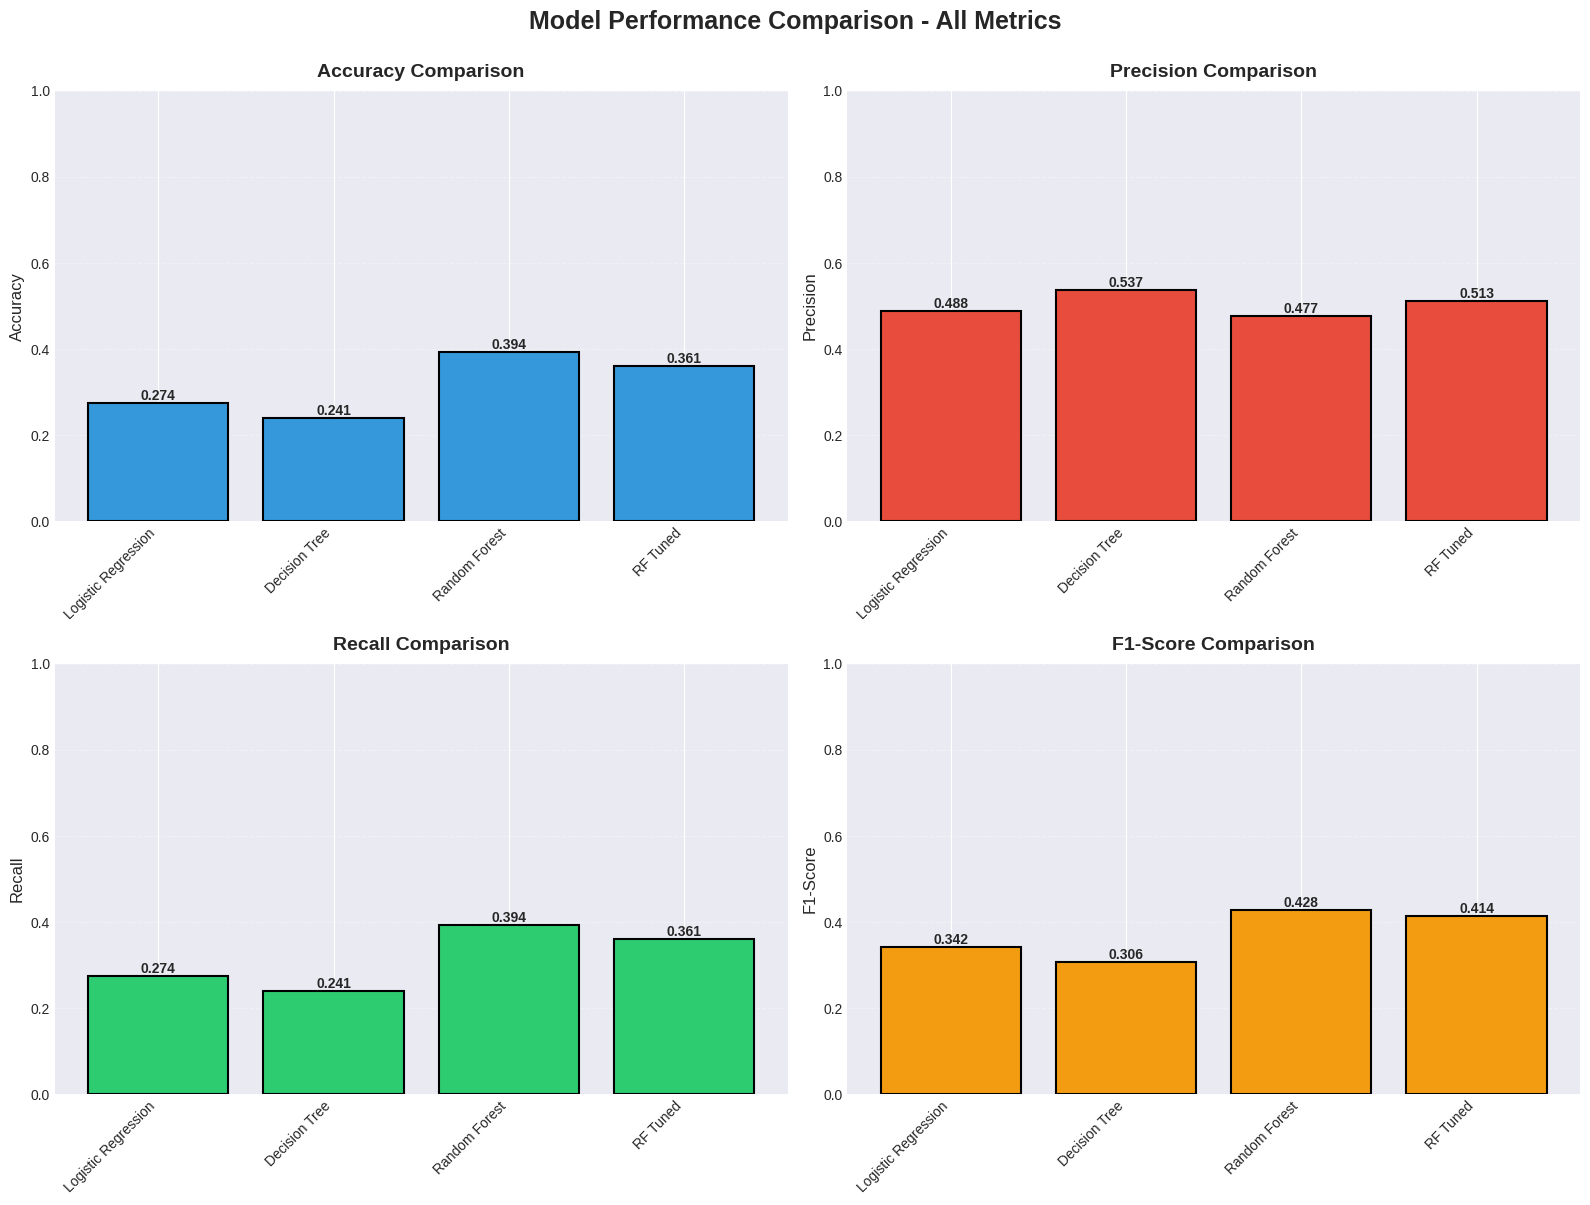

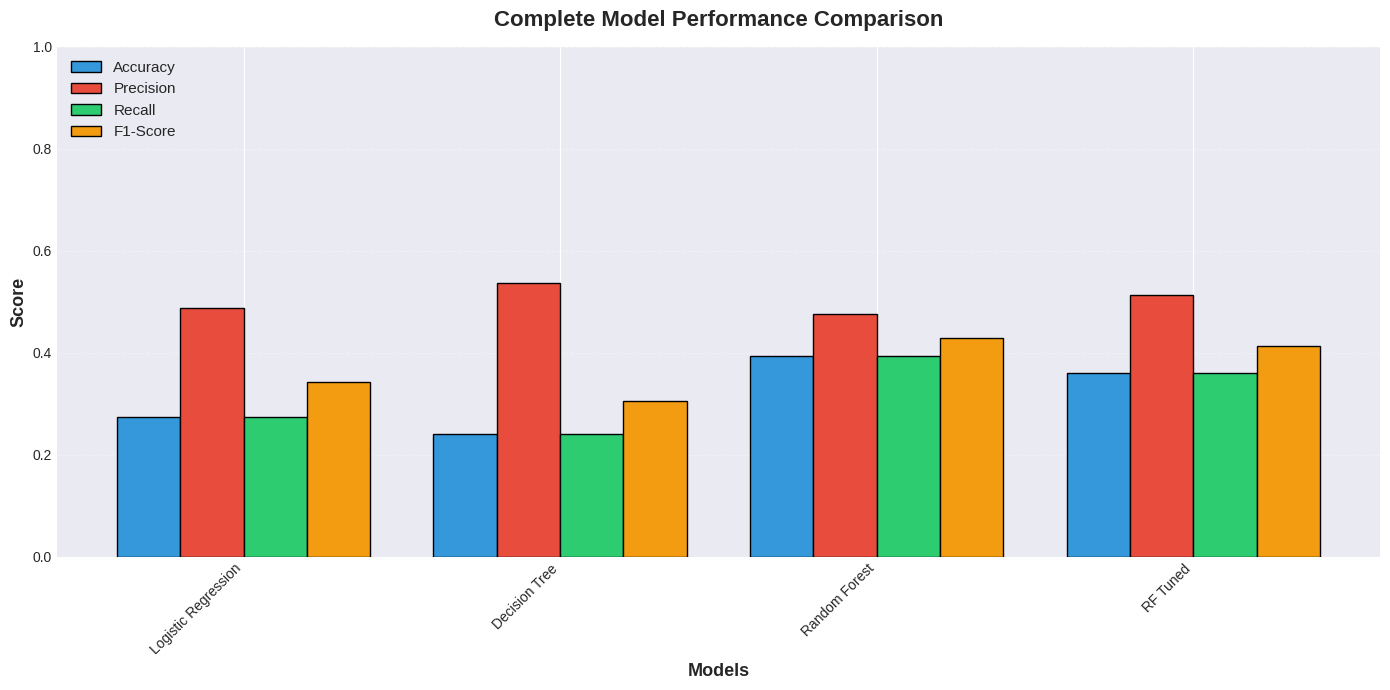

In [10]:
# Create comprehensive bar graph comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison - All Metrics', fontsize=18, fontweight='bold', y=1.00)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]

    # Plot bars
    bars = ax.bar(metrics_df['Model'], metrics_df[metric], color=color, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# Combined bar chart
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(metrics_df['Model']))
width = 0.2

bars1 = ax.bar(x - 1.5*width, metrics_df['Accuracy'], width, label='Accuracy', color='#3498db', edgecolor='black')
bars2 = ax.bar(x - 0.5*width, metrics_df['Precision'], width, label='Precision', color='#e74c3c', edgecolor='black')
bars3 = ax.bar(x + 0.5*width, metrics_df['Recall'], width, label='Recall', color='#2ecc71', edgecolor='black')
bars4 = ax.bar(x + 1.5*width, metrics_df['F1-Score'], width, label='F1-Score', color='#f39c12', edgecolor='black')

ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Complete Model Performance Comparison', fontsize=16, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=11)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('combined_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

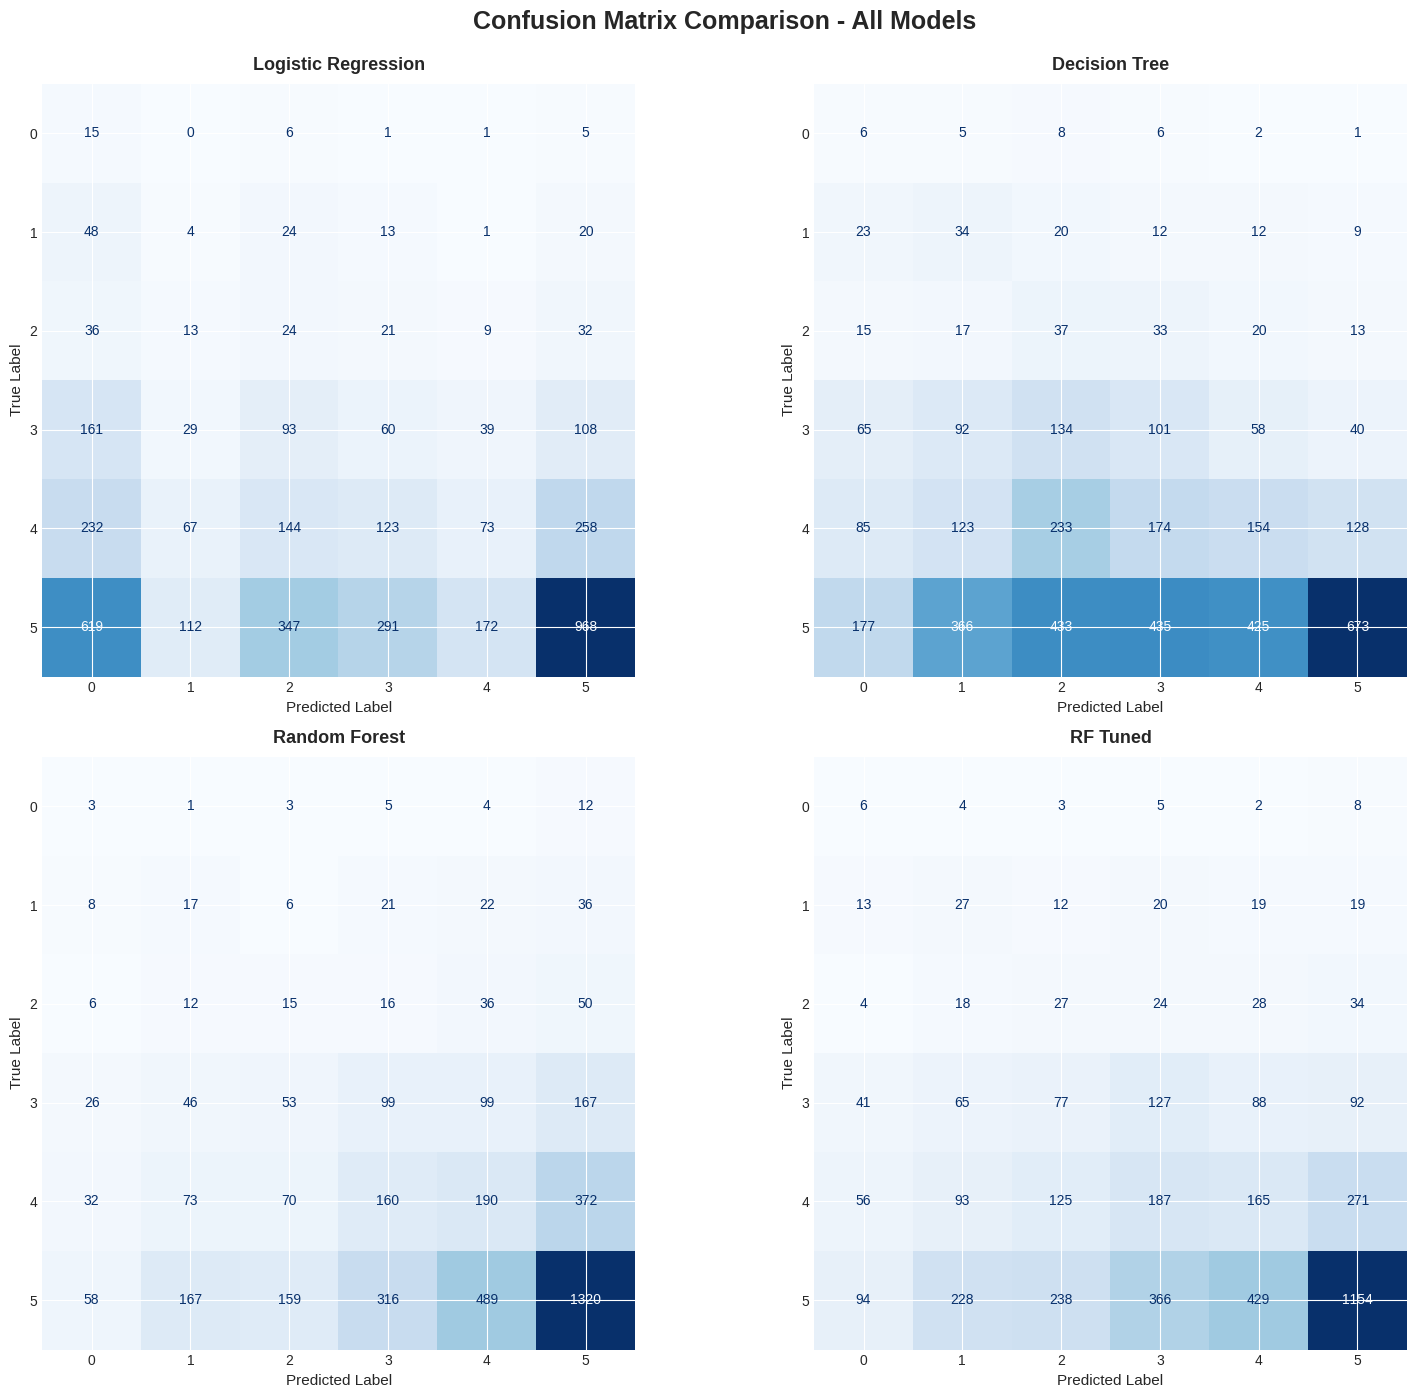

In [11]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrix Comparison - All Models', fontsize=18, fontweight='bold', y=0.995)

model_names = list(predictions_dict.keys())
for idx, model_name in enumerate(model_names):
    ax = axes[idx // 2, idx % 2]

    cm = confusion_matrix(y_test, predictions_dict[model_name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
    disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=False)

    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_ylabel('True Label', fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

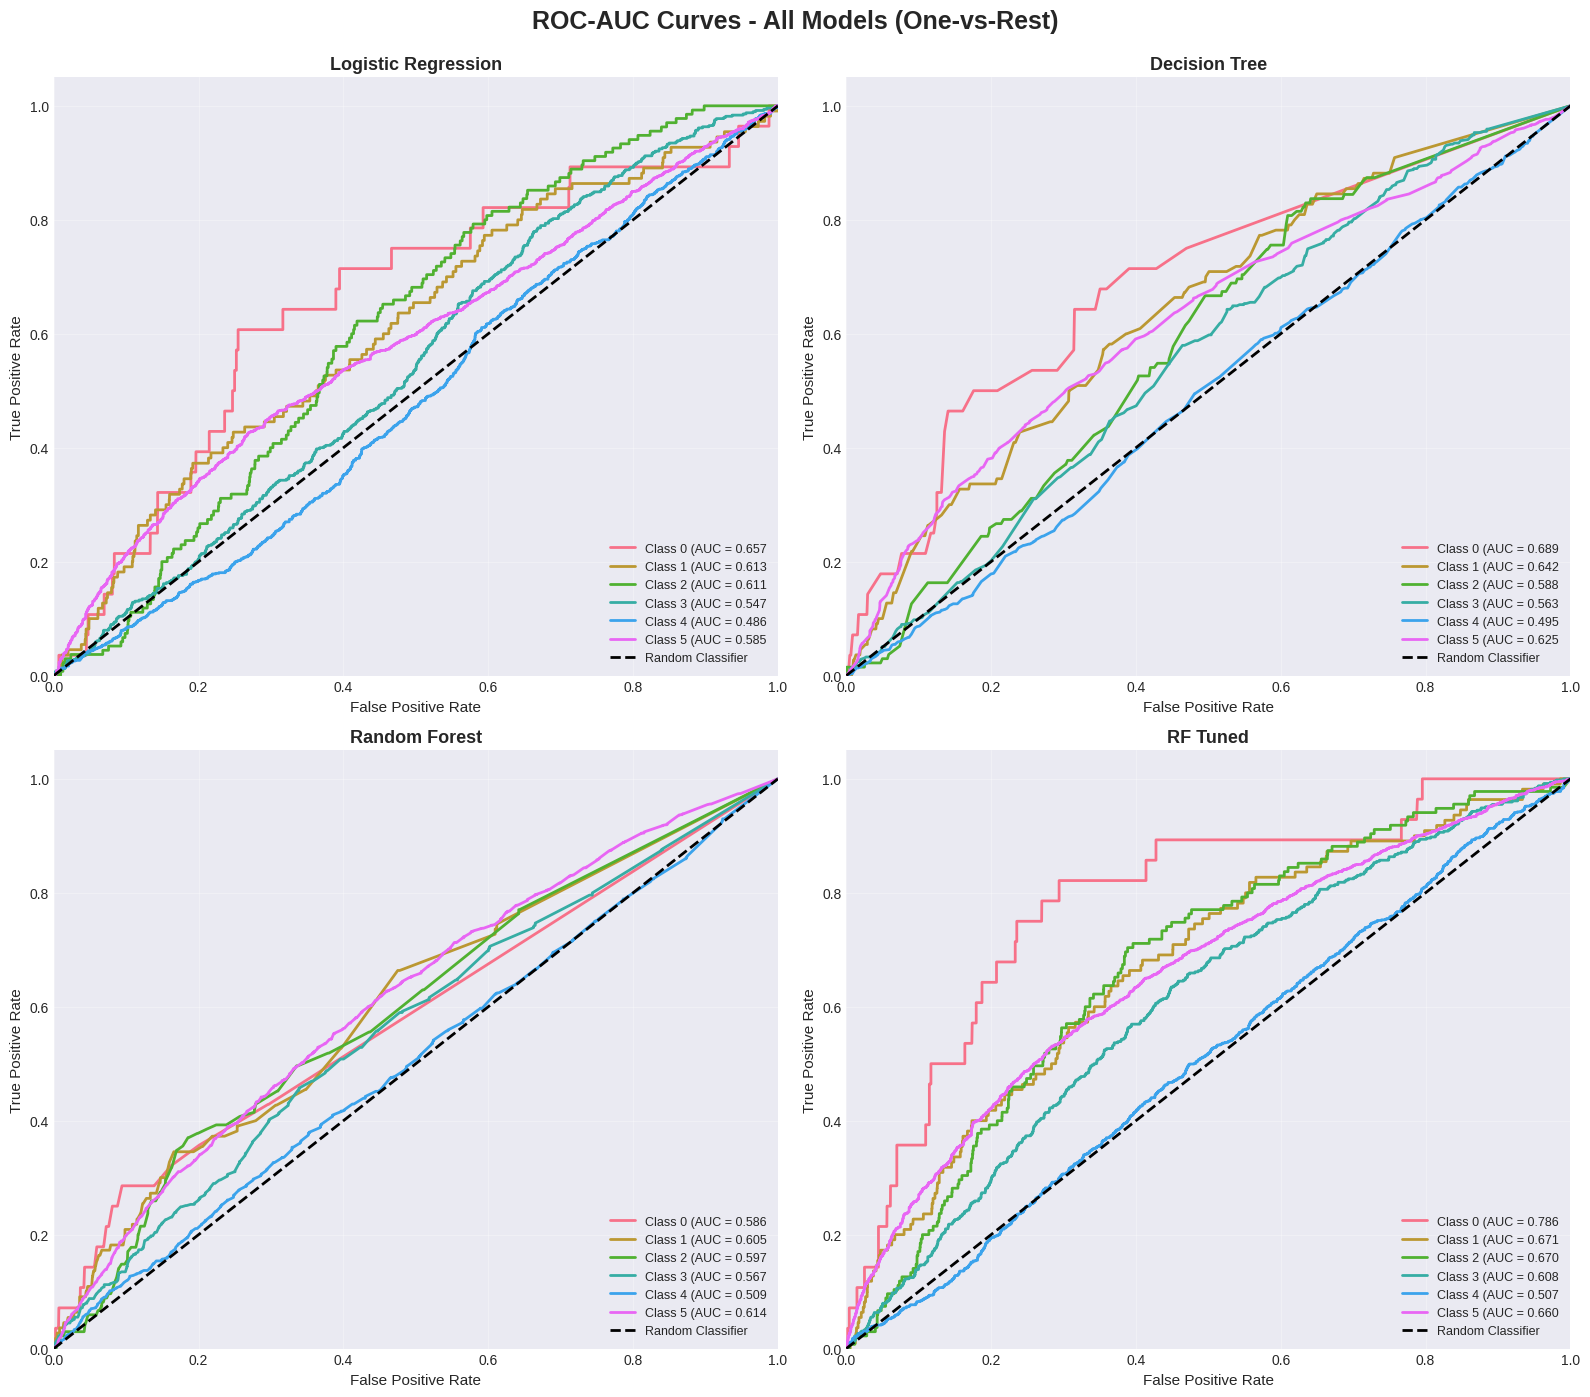

In [12]:
# Binarize the output for ROC curve
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Plot ROC curves for each model
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('ROC-AUC Curves - All Models (One-vs-Rest)', fontsize=18, fontweight='bold', y=0.995)

for idx, (model_name, y_score) in enumerate(probabilities_dict.items()):
    ax = axes[idx // 2, idx % 2]

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.3f}')

    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_auc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Print detailed classification reports for all models
print("="*80)
print("DETAILED CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*80)

for model_name, y_pred in predictions_dict.items():
    print(f"\n{'='*80}")
    print(f"MODEL: {model_name}")
    print(f"{'='*80}\n")
    print(classification_report(y_test, y_pred, target_names=[f'Rating {i}' for i in classes]))
    print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

DETAILED CLASSIFICATION REPORTS FOR ALL MODELS

MODEL: Logistic Regression

              precision    recall  f1-score   support

    Rating 0       0.01      0.54      0.03        28
    Rating 1       0.02      0.04      0.02       110
    Rating 2       0.04      0.18      0.06       135
    Rating 3       0.12      0.12      0.12       490
    Rating 4       0.25      0.08      0.12       897
    Rating 5       0.70      0.39      0.50      2509

    accuracy                           0.27      4169
   macro avg       0.19      0.22      0.14      4169
weighted avg       0.49      0.27      0.34      4169


Overall Accuracy: 0.2744

MODEL: Decision Tree

              precision    recall  f1-score   support

    Rating 0       0.02      0.21      0.03        28
    Rating 1       0.05      0.31      0.09       110
    Rating 2       0.04      0.27      0.07       135
    Rating 3       0.13      0.21      0.16       490
    Rating 4       0.23      0.17      0.20       897
    Rat


📊 Per-Class Performance Analysis - RF Tuned:
   Class  Precision   Recall  F1-Score  Support
Rating 0   0.028037 0.214286  0.049587       28
Rating 1   0.062069 0.245455  0.099083      110
Rating 2   0.056017 0.200000  0.087520      135
Rating 3   0.174211 0.259184  0.208368      490
Rating 4   0.225718 0.183946  0.202703      897
Rating 5   0.731305 0.459944  0.564717     2509


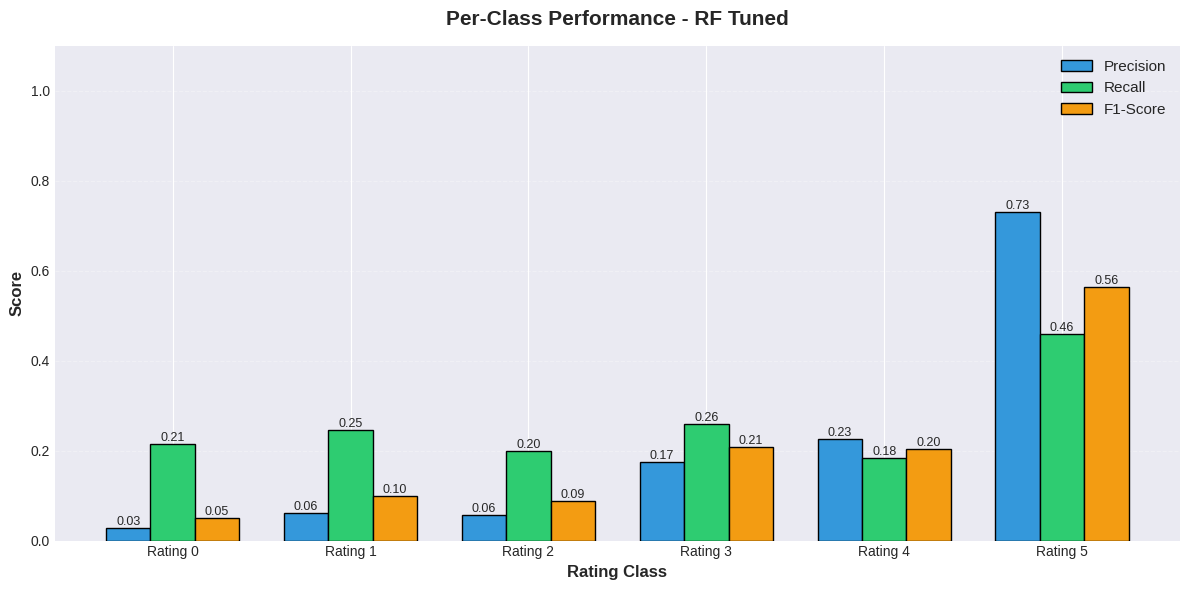

In [14]:
# Analyze per-class metrics for best model (RF Tuned)
best_model_name = 'RF Tuned'
y_pred_best = predictions_dict[best_model_name]

# Get per-class precision, recall, f1
from sklearn.metrics import precision_recall_fscore_support
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred_best, labels=classes, zero_division=0
)

# Create DataFrame
per_class_df = pd.DataFrame({
    'Class': [f'Rating {i}' for i in classes],
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})

print(f"\n📊 Per-Class Performance Analysis - {best_model_name}:")
print(per_class_df.to_string(index=False))

# Visualize per-class performance
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', color='#3498db', edgecolor='black')
bars2 = ax.bar(x, recall_per_class, width, label='Recall', color='#2ecc71', edgecolor='black')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='#f39c12', edgecolor='black')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Rating Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Per-Class Performance - {best_model_name}', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels([f'Rating {i}' for i in classes])
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

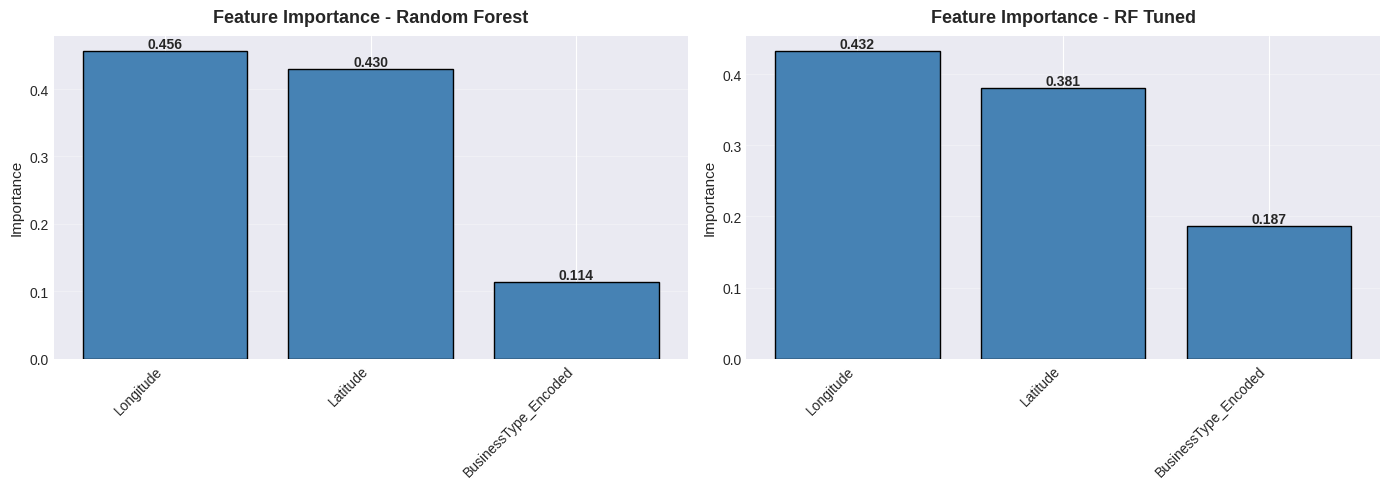

In [15]:
# Feature importance for Random Forest models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, model_name in enumerate(['Random Forest', 'RF Tuned']):
    model = models_dict[model_name]
    importances = model.feature_importances_
    feature_names = X.columns

    # Sort by importance
    indices = np.argsort(importances)[::-1]

    ax = axes[idx]
    bars = ax.bar(range(len(importances)), importances[indices], color='steelblue', edgecolor='black')
    ax.set_title(f'Feature Importance - {model_name}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
    ax.set_ylabel('Importance', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Create comprehensive summary
print("\n" + "="*100)
print("FINAL MODEL PERFORMANCE SUMMARY (Sorted by F1-Score)")
print("="*100)

summary_sorted = metrics_df.sort_values('F1-Score', ascending=False)
print(summary_sorted.to_string(index=False))

print("\n" + "="*100)
print("KEY FINDINGS")
print("="*100)

best_model_row = summary_sorted.iloc[0]
print(f"\nBEST MODEL: {best_model_row['Model']}")
print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"   Precision: {best_model_row['Precision']:.4f}")
print(f"   Recall: {best_model_row['Recall']:.4f}")
print(f"   F1-Score: {best_model_row['F1-Score']:.4f}")

print("\n CLASS IMBALANCE HANDLING:")
print("   Applied SMOTE for oversampling minority classes")
print("   Used class_weight='balanced' in all models")
print("   Resulted in more balanced predictions across all rating categories")

print("\nVISUALIZATION OUTPUTS:")
print("   Confusion Matrix Comparison (All Models)")
print("   ROC-AUC Curves (Multi-class, One-vs-Rest)")
print("   Bar Graph Comparison (All Metrics)")
print("   Classification Reports (Detailed)")
print("   Per-Class Performance Analysis")
print("   Feature Importance Comparison")

print("\n" + "="*100)
print("ANALYSIS COMPLETE! 🎉")
print("="*100)


FINAL MODEL PERFORMANCE SUMMARY (Sorted by F1-Score)
              Model  Accuracy  Precision  Recall  F1-Score
      Random Forest    0.3943     0.4766  0.3943    0.4284
           RF Tuned    0.3612     0.5128  0.3612    0.4137
Logistic Regression    0.2744     0.4877  0.2744    0.3420
      Decision Tree    0.2411     0.5367  0.2411    0.3064

KEY FINDINGS

BEST MODEL: Random Forest
   Accuracy: 0.3943
   Precision: 0.4766
   Recall: 0.3943
   F1-Score: 0.4284

 CLASS IMBALANCE HANDLING:
   Applied SMOTE for oversampling minority classes
   Used class_weight='balanced' in all models
   Resulted in more balanced predictions across all rating categories

VISUALIZATION OUTPUTS:
   Confusion Matrix Comparison (All Models)
   ROC-AUC Curves (Multi-class, One-vs-Rest)
   Bar Graph Comparison (All Metrics)
   Classification Reports (Detailed)
   Per-Class Performance Analysis
   Feature Importance Comparison

ANALYSIS COMPLETE! 🎉
